# Deep Learning &mdash; Assignment 8

Eighth assignment for the 2024 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding    

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a graph neural network, using pytorch geometric
2. Compare a GNN with other network architectures
3. Compare different GNN layers and aggregation functions

## Required software

As before you will need these libraries:
* `torch`, `torch-sparse`, `torch-scatter`, and `torch-geometric` for PyTorch,

The recommended way to install these libraries is described in the [torch-geometric installation instructions](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [1]:
# Replace ${TORCH} and ${CUDA} with your torch and cuda versions.
# Or remove the -f argument to compile from source
#
#!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
#!pip install torch-geometric

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch
import torch_geometric
from torch import nn
from torch.nn import functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()
# Override with CPU as not all code is compatible with MPS
device = torch.device("cpu")

In [2]:
class Plotter:
    """For plotting data in animation."""
    # Based on d2l.Animator
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a function to capture arguments
        def config_axes():
            axis = self.axes[0]
            axis.set_xlabel(xlabel), axis.set_ylabel(ylabel)
            axis.set_xscale(xscale), axis.set_yscale(yscale)
            axis.set_xlim(xlim),     axis.set_ylim(ylim)
            if legend:
                axis.legend(legend)
            axis.grid()
        self.config_axes = config_axes
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 8.1 A node classification dataset (1 point)

In this assignment we will be working on a node classification problem using the Citeseer dataset. This is a graph dataset that contains bag-of-words representation of documents and citation links between the documents. So there is an edge between document $i$ and document $j$ if one cites the other. This is an undirected edge.

In [3]:
dataset = Planetoid(root='data', name='Citeseer', transform=NormalizeFeatures())

**(a) How many graphs are there in this dataset? How large are they (in terms of nodes and edges)?<span style="float:right"> (1 point)</span>**

In [4]:
nr_of_graphs = dataset.len()
print(f'Number of graphs: {nr_of_graphs}')

Number of graphs: 1


In fact, we will continue the rest of this notebook using the first graph from the dataset.

In [5]:
data = dataset[0]  # Get the first graph object.

We will be use a subset of the nodes for training, and another subset for testing.
These subsets are indicated by `data.train_mask` and `data.test_mask` respectively.

## 8.2 MLP for node classification (6 points)

In theory, we should be able to classify documents based only on their content, that is, using the bag-of-words features, without taking the graph structure into account.

We can verify that by constructing a simple node-wise multilayer perceptron with a single hidden layer. This network does not use the edge information at all.

**(a) Complete the code below.<span style="float:right"> (2 points)</span>**

The network should have 2 linear layers. The hidden layer should have size `hidden_channels`, use ReLU activations, and use dropout with a dropout rate of 0.1. Don't use an activation function after the final layer.

Hint: avoid using `Sequential`, it will make the assignment harder later on.

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        self.linear1 = torch.nn.Linear(num_features, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.1)
        self.linear2 = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

**(b) Complete the training loop below.<span style="float:right"> (2 points)</span>**

Hint: compute the loss only on the training nodes.

Hint 2: `data.x` contains the features for each node, `data.y` contains their labels.

Hint 3: `model()` takes two parameters: a tensor of node features, and a tensor of edges. See the `test_accuracy` function.

In [10]:
def accuracy(pred_y, true_y):
    correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

def evaluate(model, data):
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index)
        # Compute loss and accuracy only on the 'test' nodes
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        test_acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        # Compute loss and accuracy only on the 'train' nodes
        train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask]).item()
        train_acc = accuracy(out[data.train_mask], data.y[data.train_mask])
        return train_loss, train_acc, test_loss, test_acc

def train(model, data, lr=0.01, weight_decay=5e-4, num_epochs=400, plot=True):
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()
    if plot:
        plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                          legend=['train loss', 'train accuracy', 'test loss', 'test accuracy'])
    
    for epoch in range(1, num_epochs+1):
        model.train()
        # TODO: Compute and optimize loss
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Compute test accuracy, and plot
        if plot and epoch % 10 == 0:
            train_loss, train_acc, test_loss, test_acc = evaluate(model, data)
            plotter.add(epoch + 1, (train_loss, train_acc, test_loss, test_acc))
    
    # Print final accuracy
    train_loss, train_acc, test_loss, test_acc = evaluate(model, data)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')
    return train_loss, train_acc, test_loss, test_acc

**(c) Now construct and train an MLP on this dataset.<span style="float:right"> (1 point)</span>**

Train loss: 0.0781, Train accuracy: 1.0000
Test loss: 1.2026, Test accuracy: 0.6070


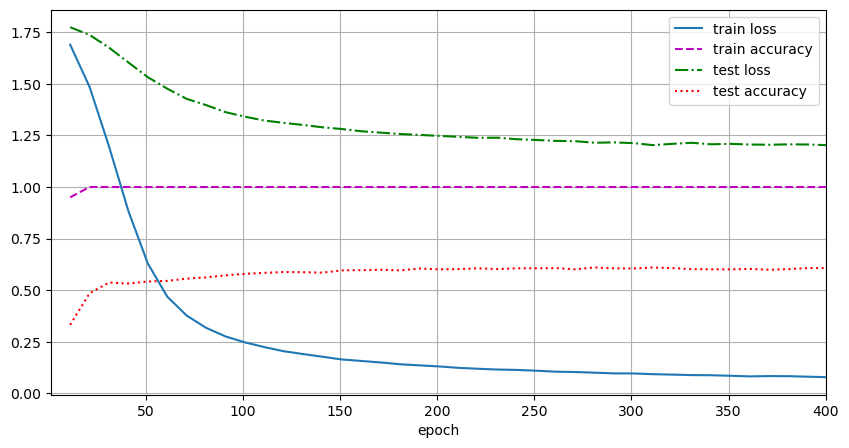

In [10]:
# TODO: construct and train the model
mlp_model = MLP(num_features=data.num_features, num_classes=dataset.num_classes)
train(mlp_model, data)

**(d) The MLP network does not use the citation information at all. Give a way to incorporate the edge information without using a graph neural network?<span style="float:right"> (1 point)</span>**

Note that the method should still work for arbitrary citation graphs.

By encoding the neighborhood relationships (edges or in this case citations) as additional features into the node representation, the prediction can include context, also without the usage of graph neural networks. These additional features could be inspired by:

* The node's degree (amount of neighbors)
* Some clustering coefficient, measuing how tightly the local neighborhood is connected
* Feature aggregation from neighboring nodes, averaged
* ...

## 8.3 A graph convolutional neural network (3 points)

Next, we will use a graph neural network based on the Graph Convolutional Network approach, which was introduced in the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf).

**(a) Implement a graph convolutional neural network, by replacing the linear layers in the MLP with [`GCNConv` layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), and train the network.<span style="float:right"> (1 point)</span>**

The network should have two `GCNConv` layers. The rest of the architecture should stay as close as possible to the MLP.

Train loss: 0.1868, Train accuracy: 1.0000
Test loss: 0.9444, Test accuracy: 0.7150


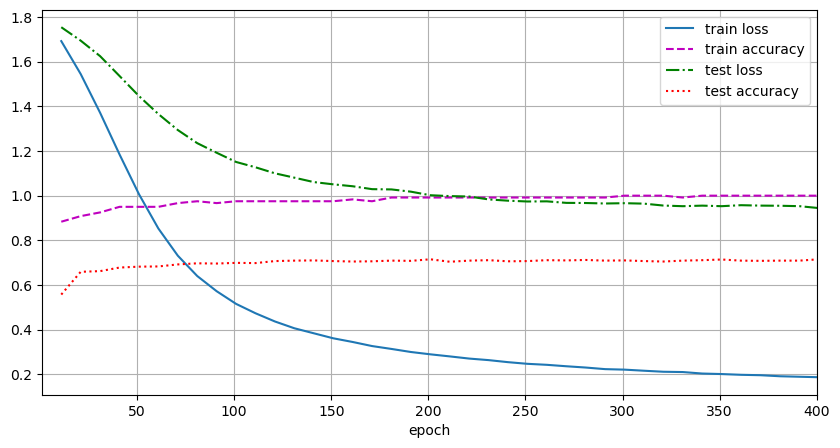

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        # TODO: initialize network layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.1)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # TODO: compute network output
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# TODO: construct and train the model
gcn_model = GCN(num_features=data.num_features, num_classes=dataset.num_classes)
train(gcn_model, data)

**(b) Compare the results of the MLP and the GCN. Which model is better?<span style="float:right"> (1 point)</span>**

The accuracy on the training set is for both models 1.0, but the CGN outperforms the MLP in the generalisation to the testing set with 0.7 compared to 0.6.

**(c) Has the GCN training converged? Can you expect higher test accuracies by training longer? Explain your answer.<span style="float:right"> (1 point)</span>**

The GCN seems to have converged. The performance on the test and train set have platoed from about 100 (maybe 200) episodes onwards. Also the loss is almost flat.

## 8.4 Comparing GNN layers (8 points)

Two graph layers that are interesting to compare are [`SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). Aside from one of them supporting weighted graphs, these models differ only in the accumulation function.

**(a) Look at the documentation for these two layers. What is the difference in the accumulation function?<span style="float:right"> (1 point)</span>**

While `SAGEConv` allows for different aggragation schemes, the deafault is a simple "mean" operation, taking the mean of all neighbors feature vectors.

In contrast, `GraphConv` aggregates the information from neighboring nodes by computing a (weighted) sum of the feature fectors of the neighbors.

As also highlighted in the [Bishop book](https://www.bishopbook.com), the missing normalisation factor when computing a (weighted) sum allowes the model to learn about the nodes degree more explicitly. The normalisation removes the 'scale' as source of information and is therefore often considered less powerfull, but could contribute to more stabile learning and improve generalization in applications where degree information is less very relevant.

To avoid having to copy the GNN structure every time, we can make our code generic in the type of layer to use.

**(b) Make a generic graph neural network, that uses layers of type `layer_type`.<span style="float:right"> (1 point)</span>**

Hint: you can construct layers with `my_layer = layer_type(in_size, out_size, **layer_args)`.

In [8]:
class GNN(torch.nn.Module):
    def __init__(self, layer_type, num_features, num_classes, hidden_channels=16, **layer_args):
        super().__init__()
        # TODO: initialize network layers
        self.conv1 = layer_type(num_features, hidden_channels, **layer_args)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.1)
        self.conv2 = layer_type(hidden_channels, num_classes, **layer_args)

    def forward(self, x, edge_index):
        # TODO: same as before
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

**(c) Train a SAGEConv network and a GraphConv network.<span style="float:right"> (no points)</span>**

Train loss: 0.0520, Train accuracy: 1.0000
Test loss: 0.9299, Test accuracy: 0.7050


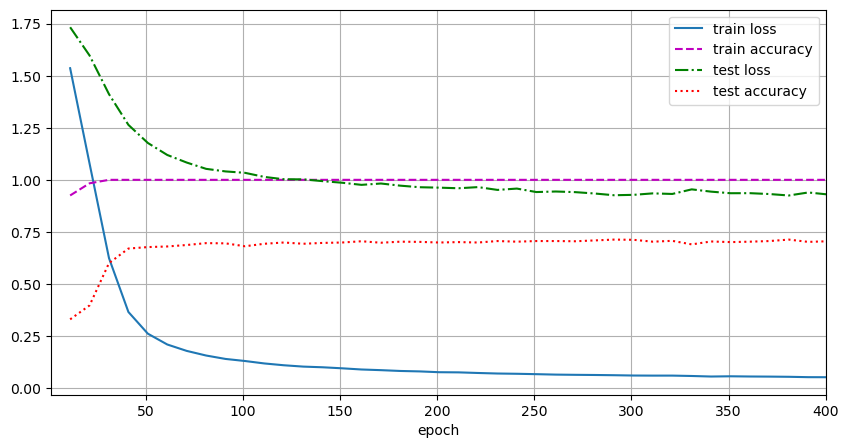

In [15]:
# TODO: construct and train a GNN with SAGEConv layers
sageconv_model = GNN(SAGEConv, num_features=data.num_features, num_classes=dataset.num_classes)
train(sageconv_model, data)

Train loss: 0.0227, Train accuracy: 1.0000
Test loss: 1.3664, Test accuracy: 0.6430


(0.022683484479784966, 1.0, 1.3663698434829712, 0.643)

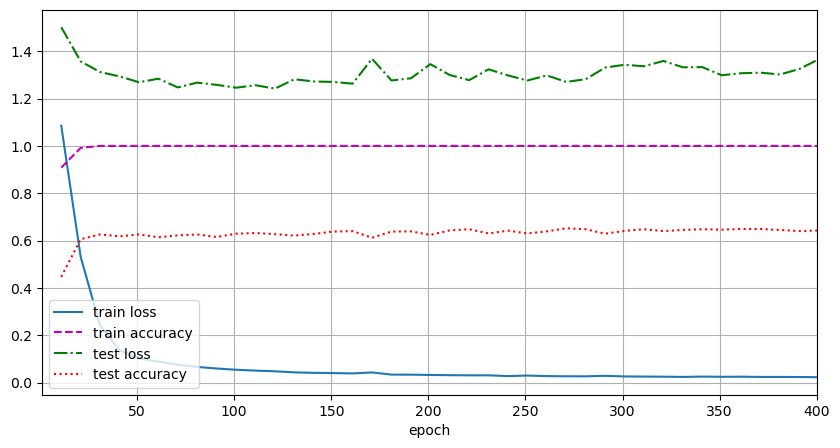

In [12]:
# TODO: construct and train a GNN with GraphConv layers
graphconv_model = GNN(GraphConv, num_features=data.num_features, num_classes=dataset.num_classes)
train(graphconv_model, data)

**(d) Compare the performance of these two models, and also compare them to the GCN.<span style="float:right"> (1 point)</span>**

Hint: look at the test loss.

TODO: your answer here

**(e) Can you explain the observation in the previous question by looking at the aggregation functions? Why is one of them worse than the others?<span style="float:right"> (1 point)</span>**

TODO: your answer here

In fact, it is possible to use different aggregation functions, by passing `aggr=` to the network constructor.

**(f) Compute the performance for `GraphConv` networks with `'mean'`, `'sum'`, `'min'`, `'max'`, and `'std'` aggregation.<span style="float:right"> (1 point)</span>**

Hint: train with `plot=False` to only show the final loss and accuracy.

Hint 2: if the performance is the same for all methods, there is most likely a bug in your `GNN` code.

Train loss: 0.0714, Train accuracy: 1.0000
Test loss: 1.1795, Test accuracy: 0.6420


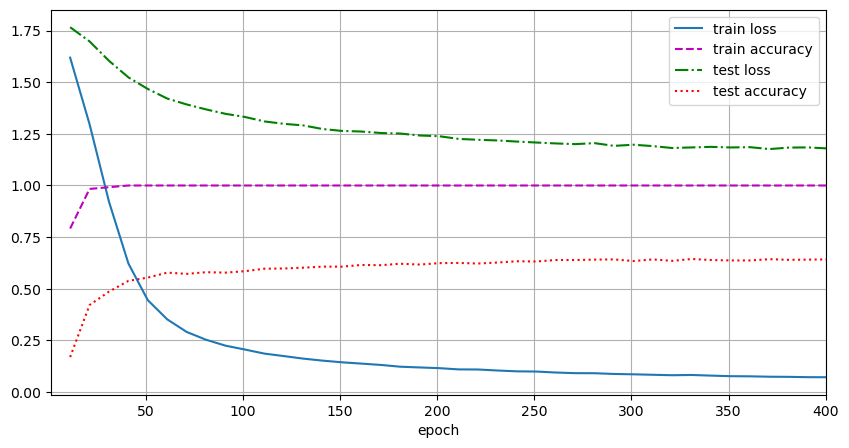

Aggregator: mean, Train accuracy: 1.0000, Test accuracy: 0.7050
Aggregator: sum, Train accuracy: 1.0000, Test accuracy: 0.6510
Aggregator: min, Train accuracy: 1.0000, Test accuracy: 0.6790
Aggregator: max, Train accuracy: 1.0000, Test accuracy: 0.6520
Aggregator: std, Train accuracy: 1.0000, Test accuracy: 0.6420


In [11]:
# TODO: Your experiment here
dict_train_test_acc = {}
for aggr in ['mean', 'sum', 'min', 'max', 'std']:
    print(f'Aggregator: {aggr}')
    experiment_model = GNN(GraphConv, num_features=data.num_features, num_classes=dataset.num_classes, aggr=aggr)
    train_loss, train_acc, test_loss, test_acc = train(experiment_model, data)
    dict_train_test_acc[aggr] = (train_acc, test_acc)
    plt.show()

for aggr, (train_acc, test_acc) in dict_train_test_acc.items():
    print(f'Aggregator: {aggr}, Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

**(g) Which three aggregation methods are the worst? For each one, explain why that one would not work well.<span style="float:right"> (3 points)</span>**

Hint: bag-of-word features are very sparse.

TODO: your answer here

## 8.5 Discussion (3 points)

**(a) We have split the data by picking some nodes for training, and some for testing. But the graph contains edges between training and testing nodes, so the training procedure has to use the entire graph, including test nodes. Is it possible for the model to cheat using leaked information about the test nodes?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(b) Can the GCN and GNN networks use information from neighbors of neighbors to classify a node? Briefly explain your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(c) Do you think the trained model will generalize to other graphs? Motivate your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 21 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version f8cf264 / 2024-10-21</span>